# Cell Co-registraiton with two channels

In this Notebook, we demonstrate cell coregistraion with Anti-GFP and Anti-CD206 channels.

### Imports

In [67]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import platform
print(platform.python_version())
import sys
sys.path.append('/home/mykim/workspace/repos/chunglab/bmtrap_2021/bmtrap')
sys.path.append('/home/mykim/cbm/src/')
import matplotlib.pyplot as plt
import numpy as np
import zarr
import json

from bmtrap.coreg import coReg
from utils.data.preprocessing import BMPreprocessing as BMPrep
from bmtrap.params import BaseParams
from utils import *
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from tqdm import tqdm

# Create Colormap
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
N = 256
color = np.ones((N, 4))
color[:, 0] = np.linspace(0, 255/256, N) # R = 255
color[:, 1] = np.linspace(0, 0, N) # G = 232
color[:, 2] = np.linspace(0, 255/256, N)  # B = 11
magenta = ListedColormap(color)
magenta_r = magenta.reversed()
color = np.ones((N, 4))
color[:, 0] = np.linspace(0, 0, N) # R = 255
color[:, 1] = np.linspace(0, 255/256, N) # G = 232
color[:, 2] = np.linspace(0, 255/256, N)  # B = 11
cyan = ListedColormap(color)
cyan_r = cyan.reversed()

rd = np.ones((N, 4))
rd[:, 0] = np.linspace(255/256, 0, N) # R = 255
rd[:, 1] = np.linspace(0, 0, N) # G = 232
rd[:, 2] = np.linspace(255/256, 0, N)  # B = 11
rd_cmp = ListedColormap(rd)
rd_cmp_r = rd_cmp.reversed()
gd = np.ones((N, 4))
gd[:, 0] = np.linspace(0, 0, N) # R = 255
gd[:, 1] = np.linspace(255/256, 0, N) # G = 232
gd[:, 2] = np.linspace(255/256, 0, N)  # B = 11
gd_cmp = ListedColormap(gd)
gd_cmp_r = gd_cmp.reversed()

# Create BMPreprocessing() Object
bmPrep = BMPrep()

3.7.9


### Create CoReg Object with data

In [120]:
dpaths = {
    'E10.5':'/media/share7/MYK/MorPheT/data/images/E10.5/20220416_17_26_08_10E_E10.5_GFP_CD206_aGFP',
    197:'/media/ssdshare2/general/MYK/data/MorPheT/E13.5/20230219_18_36_48_197_E13.5_aGFP_none_CD206',
    132:'/media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230501_20_30_11_132_E15.5_aGFP_none_CD206',
    137:'/media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230502_13_33_58_137_E15.5_aGFP_none_CD206',
    175:'/media/ssdshare2/general/MYK/data/MorPheT/E15.5/20230430_17_35_33_175_E15.5_aGFP_none_CD206',
    167:'/media/ssdshare2/general/MYK/data/MorPheT/P0/20230506_17_21_47_167_P0_hemi-2_aGFP_none_CD206',
}
sample_id = 197
dpath = dpaths[sample_id]
ar_data = {
        '14D': 5000. / 4300, 
        '14E': 5324/3600. , 
        '14F': 5300./4300 , 
        '15F': 3599 / 5327.,
        '15G': 3599 / 5327.,
        '15H': 3200/ 4600., 
        '16D': 8928/12419. ,
        '9C': 3800 / 3300,
        '10E': 3800 / 3000,
        '132': 2742. / 5355.,
        '137': 2751. / 5328.,
        '175': 2750. / 5325.,
        '167': 3599. / 6206.
    
}
ar_default = 0.51

# zr = [1077, 1093]
#xr = [1200, 2200]
#yr = [2200, 3200]
#xr = [857, 1607]
#yr = [1672, 2422]
#zr = [1030, 1046]
#xr = [1300, 2050]
#yr = [1000, 1750]
#zr = [950, 966]
#zr = [1340, 1356]
#xr = [500, 1500]
#yr = [1500, 2500]

if sample_id == 137:
    zr = [622, 638]
    xr = [950, 1850]
    yr = [1450, 2450]
elif sample_id == 175:
    zr = [1150, 1170]
    xr = [700, 1300]
    yr = [1900, 2500]
elif sample_id == 197:
    zr = [840, 856]
    yr = [2500, 3000]
    xr = [1300, 1800]

params_f = os.path.join(dpath, 'params.json')
with open(params_f) as fp:
    params = json.load(fp)
print(params['AntiGFP'])

# HARD-CODED!
params['sample_id'] = sample_id

{'cc_csv': 'cell_centers_AntiGFP.csv', 'cc_npy': 'cell_centers_AntiGFP.npy', 'ccd_phathom_param_json': 'ccd_phathom_params_AntiGFP.json', 'clim': [800, 8000], 'shape': [2100, 4469, 2732], 'tif_rel_path': 'Ex_488_Em_0_destriped_stitched_master_downsampled2x', 'zarr_rel_path': 'Ex_488_Em_0_destriped_stitched_master_downsampled2x_zarr'}


In [121]:
dname = "%s_%s"%(params['age'], sample_id)
try:
    ar = ar_data[sample_id]
except KeyError:
    ar = ar_default
print("sample_id: ", sample_id)
print("dname: ", dname, 'ar: ', ar)
subdir = '_'.join(params['d_root'].split('/')[-1].split('_')[-5:])
print("%s"%subdir)
savepath = '/media/ssdshare2/general/MYK/data/analysis/coPos/%s'%subdir


AntiGFP_zpath = os.path.join(dpath, params['AntiGFP']['zarr_rel_path'])
CD206_zpath = os.path.join(dpath, params['CD206']['zarr_rel_path'])

src_cc_file = os.path.join(dpath, params['AntiGFP']['cc_npy'])
src_cc_file_csv = os.path.join(savepath, params['AntiGFP']['cc_csv'])
src_cc_file_csv2 = os.path.join(dpath, params['AntiGFP']['cc_csv'])

sample_id:  197
dname:  E13.5_197 ar:  0.51
197_E13.5_aGFP_none_CD206


### Create coReg() object, load data, and Visualize

In [122]:
threshold = 0.88
#threshold = 0.7
#args_561 = ['trap', '-sz', c642_zpath, '-sp', savepath, '-sc', src_cc_file, '-dz', c561_zpath, '-dp', c561_ppath, '-thr', str(threshold), '-dbg']
#p561 = BaseParams()
#p561.build(args_561, 'morphet_parser-561')
args_CD206 = ['trap', '-sz', AntiGFP_zpath,
              '-sp', savepath, '-sc', src_cc_file,
              '-dz', CD206_zpath, '-dp', "%s_prob"%CD206_zpath,
              '-thr', str(threshold), '-dbg']
pCD206 = BaseParams()
pCD206.build(args_CD206, 'morphet_parser-CD206')
cr = coReg(pCD206)
cr.load_data()
print(cr.src_vol.shape, len(cr.src_cc), cr.dst_vol.shape, cr.dst_probs.shape)
sub_svol, sub_dvol, sub_dpmap = cr.get_subvol(xr=xr, yr=yr, zr=zr)

[---------- BaseParams() Variables and their values (BEGIN) ----------]
[ debug ]	: True
[ dst_probpath ]	: /media/ssdshare2/general/MYK/data/MorPheT/E13.5/20230219_18_36_48_197_E13.5_aGFP_none_CD206/Ex_642_Em_2_destriped_stitched_downsampled2x_zarr_prob
[ dst_tifpath ]	: None
[ dst_zarrpath ]	: /media/ssdshare2/general/MYK/data/MorPheT/E13.5/20230219_18_36_48_197_E13.5_aGFP_none_CD206/Ex_642_Em_2_destriped_stitched_downsampled2x_zarr
[ save_path ]	: /media/ssdshare2/general/MYK/data/analysis/coPos/197_E13.5_aGFP_none_CD206
[ src_cc ]	: /media/ssdshare2/general/MYK/data/MorPheT/E13.5/20230219_18_36_48_197_E13.5_aGFP_none_CD206/cell_centers_AntiGFP.npy
[ src_tifpath ]	: None
[ src_zarrpath ]	: /media/ssdshare2/general/MYK/data/MorPheT/E13.5/20230219_18_36_48_197_E13.5_aGFP_none_CD206/Ex_488_Em_0_destriped_stitched_master_downsampled2x_zarr
[ threshold ]	: 0.88
[ viz ]	: False
[---------- BaseParams() Variables and their values (END) ----------]
(2100, 4469, 2732) 60629 (2100, 4469, 2732

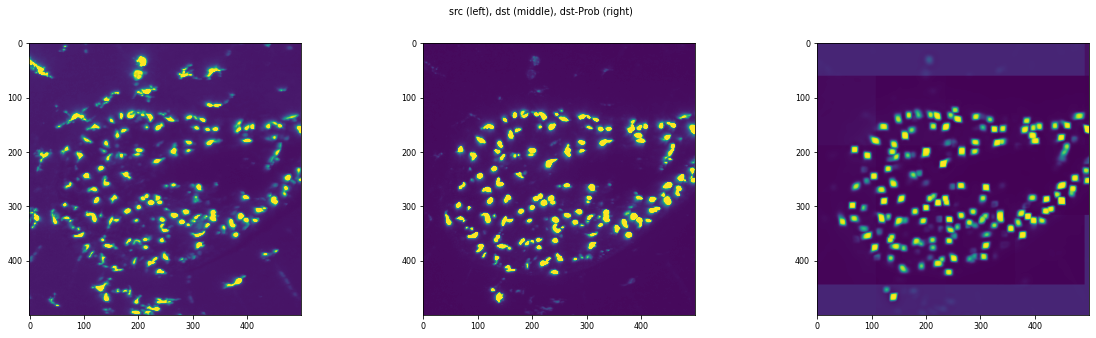

0.00018773972 0.9999981


In [123]:
cr.visualize(sub_svol, sub_dvol, sub_dpmap, clim=[400, 8000])
print(np.min(sub_dpmap), np.max(sub_dpmap))
#print(sub_dpmap.shape)
#plt.imshow(sub_dpmap[1], clim=[0.4, 1.0])
#plt.show()

### Run Copositivity Detection

In [124]:
spath = savepath
#spath = '/media/ssdshare2/general/MYK/data/analysis/coPos/167-2_P0_aGFP_none_CD206'
coposf = os.path.join(spath, 'CoPosCC_ccPos_thr_%.2f.npy'%cr.params.threshold)

try:
    print("looking for the file at: %s"%coposf)
    cp_ccl = np.load(coposf)
except FileNotFoundError:
    print("Running CoPos Detection...")
    # has not run w/ the threshold
    outs = cr.find_coPos(viz=False, save=True)
    stacked=[]
    for item in outs:
        stacked += [list(x) for x in item]
    cp_ccl = np.array(stacked)

looking for the file at: /media/ssdshare2/general/MYK/data/analysis/coPos/197_E13.5_aGFP_none_CD206/CoPosCC_ccPos_thr_0.88.npy


### Grab Co-Positive cells and Visualize

In [125]:
zr_w_damp = [zr[0]-10, zr[1]+10]

src_sub_cc = cr.get_cc_in_region(cr.src_cc, xr, yr, zr_w_damp, relative=True)
print("%d / %d selected."%(len(src_sub_cc), len(cr.src_cc)))
src_sub_xs = src_sub_cc[:, 2]
src_sub_ys = src_sub_cc[:, 1]

cp_sub_ccl = cr.get_cc_in_region(cp_ccl, xr, yr, zr_w_damp, relative=True)
print("%d / %d selected."%(len(cp_sub_ccl), len(cp_ccl)))
cp_ccl_xs = cp_sub_ccl[:, 2]
cp_ccl_ys = cp_sub_ccl[:, 1]
cfos_pmpt = cr.dst_pmap_maxProj.copy()
cfos_pmpt[cfos_pmpt < cr.params.threshold] = 0.

181 / 60629 selected.
131 / 25009 selected.


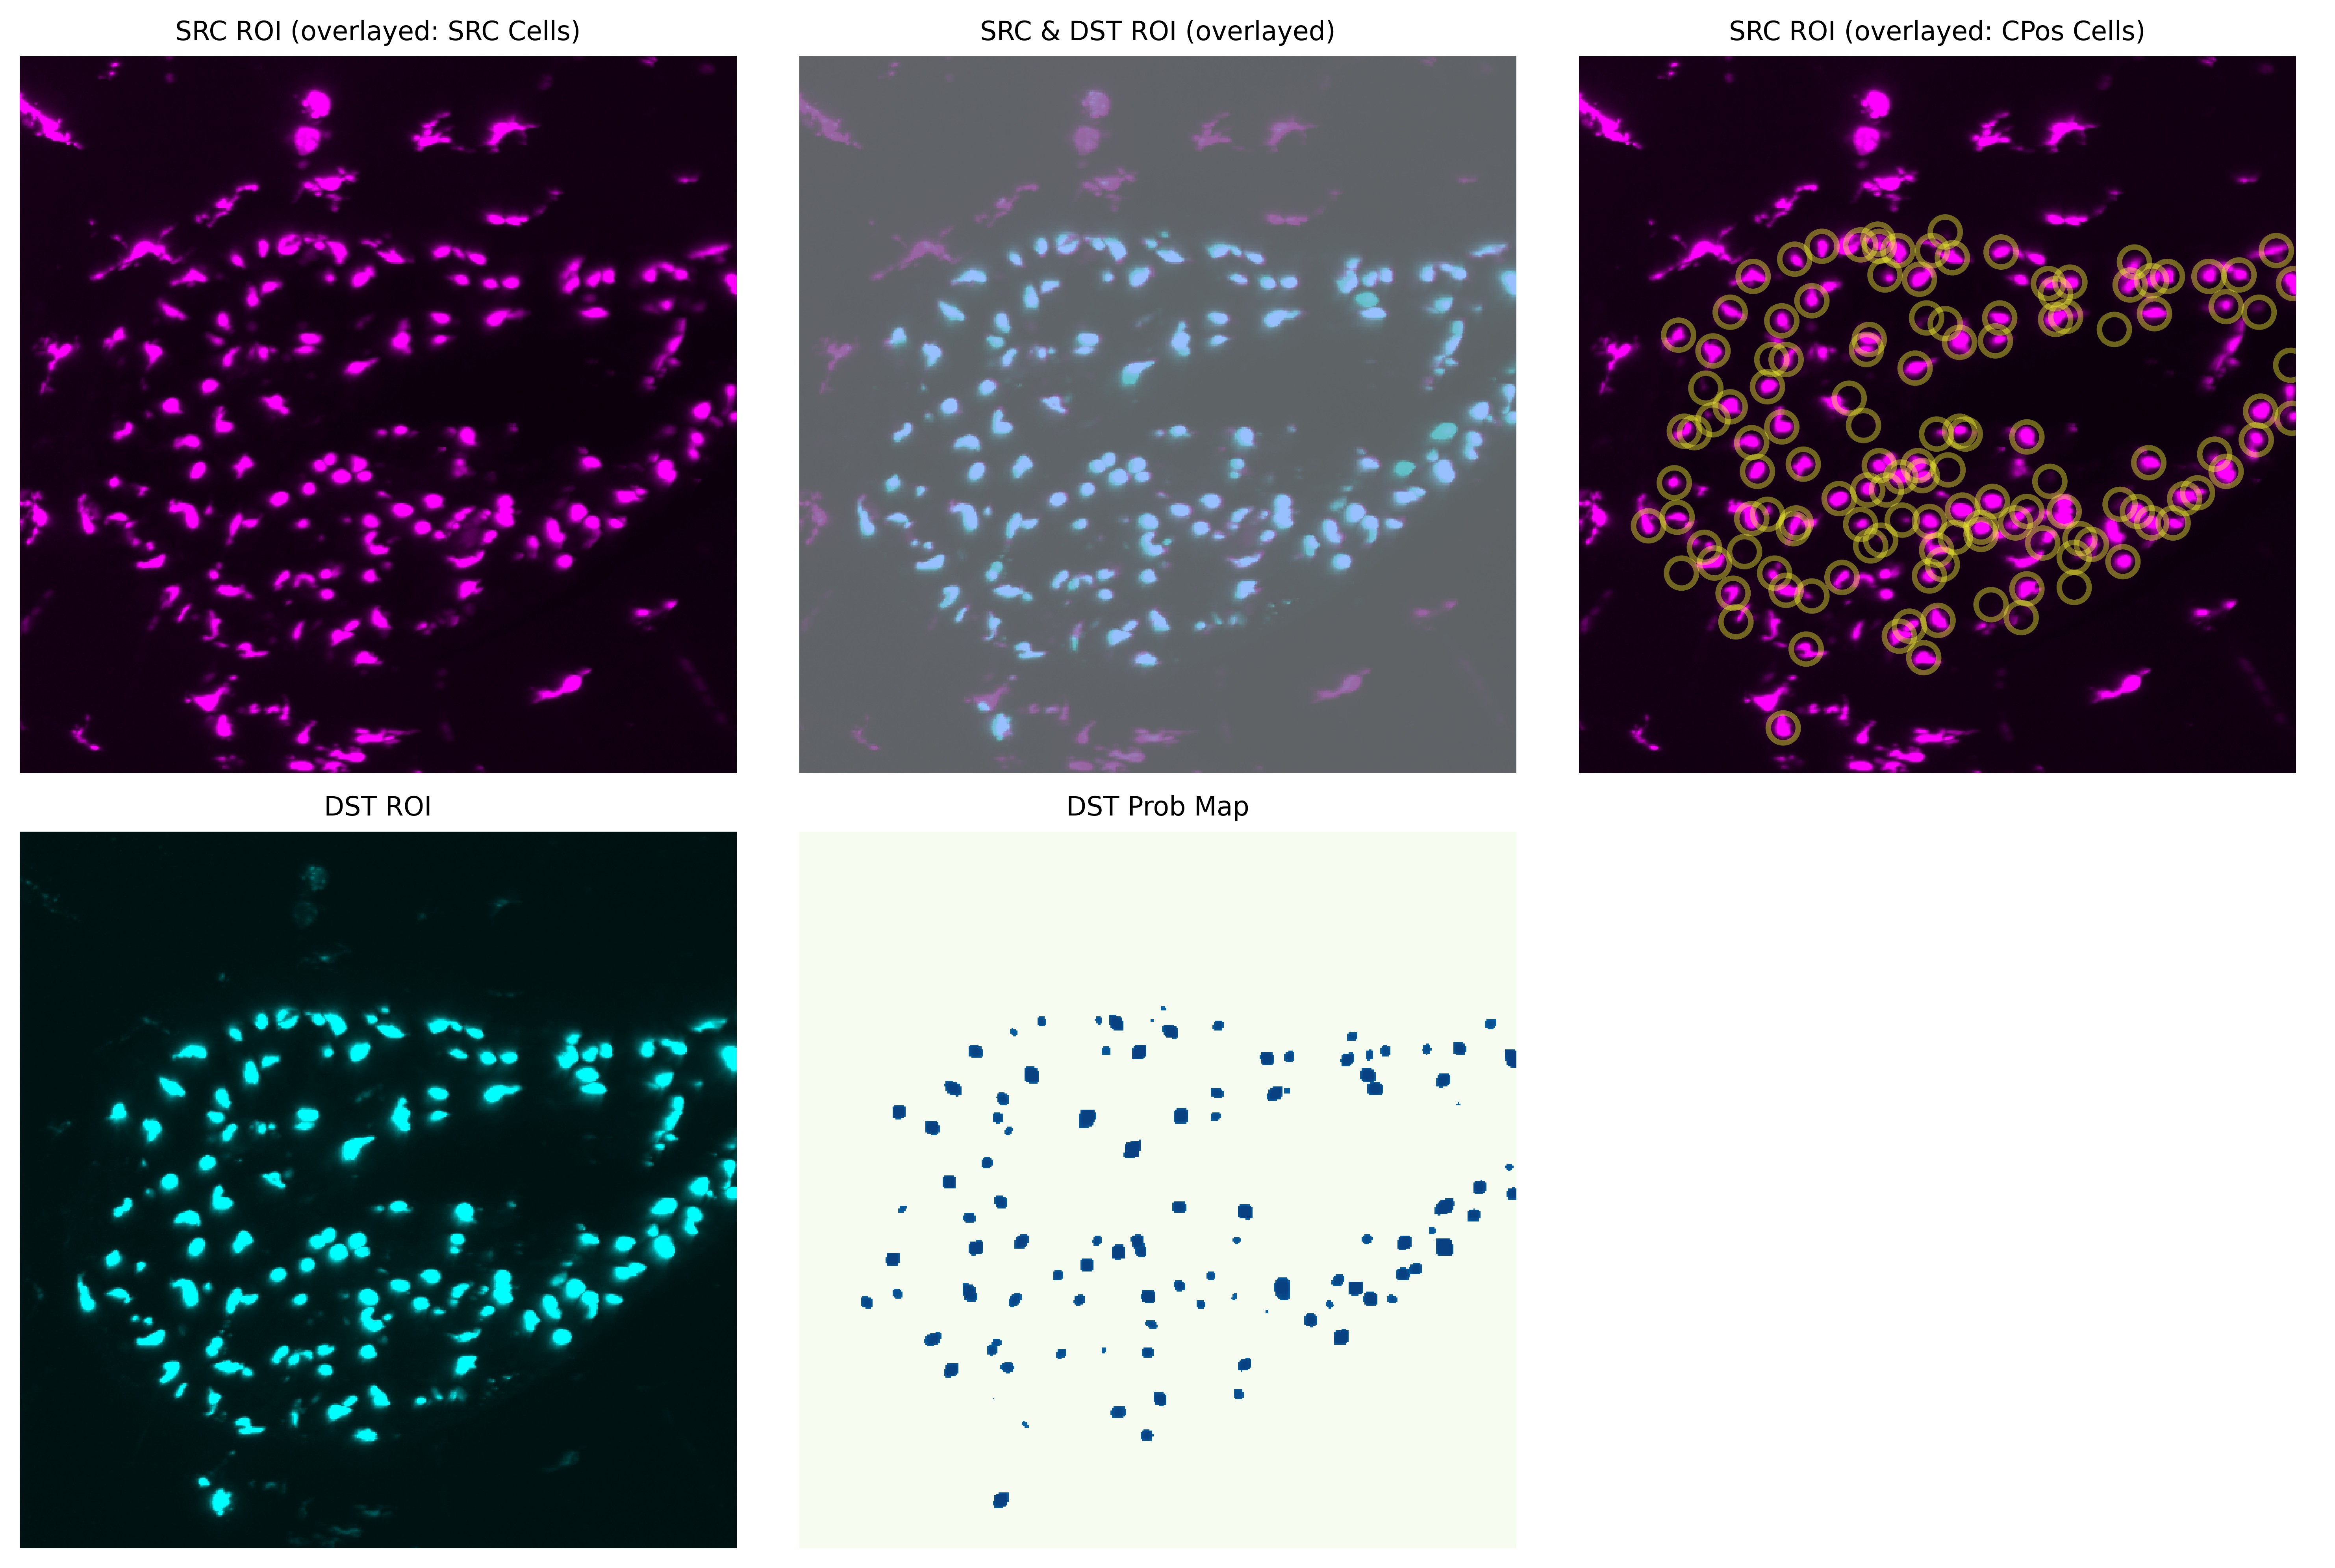

In [126]:
src_clim = [300, 8000]
dst_clim = [0, 8000]
ss = 120

fig, ax = plt.subplots(figsize=(12, 8), ncols=3, nrows=2, sharex=True, dpi=500)
ax[0][0].imshow(cr.src_maxProj, clim=src_clim, cmap=magenta)
ax[0][0].set_title("SRC ROI (overlayed: SRC Cells)")
ax[1][0].imshow(cr.dst_maxProj, clim=dst_clim, cmap=cyan)
ax[1][0].set_title("DST ROI")

ax[0][1].imshow(cr.src_maxProj, clim=src_clim, cmap=rd_cmp_r, alpha=0.4)
ax[0][1].imshow(cr.dst_maxProj, clim=dst_clim, cmap=gd_cmp_r, alpha=0.4)
ax[0][1].set_title("SRC & DST ROI (overlayed)")


ax[1][1].imshow(cfos_pmpt, cmap='GnBu')
ax[1][1].set_title("DST Prob Map")

ax[0][2].imshow(cr.src_maxProj, clim=src_clim, cmap=magenta)
ax[0][2].scatter(cp_ccl_xs, cp_ccl_ys, s=ss, facecolor='none', linewidth=2, edgecolor=[[1., 1., 0.2, .4]]) #c='w', alpha=0.4)
ax[0][2].set_title("SRC ROI (overlayed: CPos Cells)")


#ax[1][2].imshow(cr.src_maxProj, clim=src_clim, cmap=magenta)
#ax[1][2].scatter(src_sub_xs, src_sub_ys, s=20, facecolor='none', linewidth=2, edgecolor='w')


#ax[1][2].imshow(cr.dst_maxProj, clim=[500, 18000], cmap=cyan)
#ax[2].scatter(cp_ccl_xs, cp_ccl_ys, s=ss, facecolor='none', linewidth=2, marker='s', edgecolor=[[0.8, 0.8, .8, .2]])
#ax[1][2].scatter(cp_ccl_xs, cp_ccl_ys, s=ss, facecolor='none', linewidth=2, marker='s', edgecolor='y')
#ax[1][2].set_title("DST ROI (overlayed: CPos Cells)")
#ax[2][1].imshow(cfos_pmpt, cmap='GnBu')
#ax[2][1].scatter(cp_ccl_xs, cp_ccl_ys, s=ss, edgecolor='r', facecolor='none', linewidth=2, alpha=0.6)
#ax[2][1].set_title("DST ProbMap (overlayed: Co-Positive Cells)")
for aax in ax:
    for aay in aax:
        aay.axis('off')
fig.tight_layout()
plt.show()

In [84]:
print(dname)
fig.savefig("CD206_AntiGFP_CoPositivity-%s_thr-%.2f.png"%(dname, cr.params.threshold))

E13.5_197


### Heatmap

In [127]:
len(cr.src_cc), len(cp_ccl)

(60629, 25009)

In [128]:
df = pd.read_csv(src_cc_file_csv2)
df.head()

,id,z,y,x,label,BMTR-20190312-170708,TRAP-20200705-130651,ALTR-20210914-234831
0,0,85,1218,1348,-1,2,1,2
1,1,76,1188,1328,-1,0,0,2
2,2,73,1170,1330,-1,2,1,2
3,3,63,1196,1331,-1,2,1,2
4,4,79,1183,1339,-1,2,1,2


In [ ]:
if True:
    df['CD206+']=0
    for item in tqdm(cp_ccl):
        zz, yy, xx = item
        df.loc[(df['z'] == zz) & (df['y'] == yy) & (df['x']==xx), 'CD206+'] = 1

In [ ]:
df_cd206pos = df[df['CD206+']==1]
df_cd206neg = df[df['CD206+']==0]

In [ ]:
df_cd206pos.head()

In [ ]:
df_cd206neg.head()

In [ ]:
#model = 'ALTR-20210914-234831'
model = 'BMTR-20190312-170708'
df_cd206pos_ameboid = df[(df['CD206+']==1) & (df[model]==1)]
df_cd206pos_ramified = df[(df['CD206+']==1) & (df[model]==0)]
print(len(df_cd206pos_ameboid), len(df_cd206pos_ramified))
df_ameboid = df[df[model]==1]
df_ramified = df[df[model]==0]
print(len(df_ameboid), len(df_ramified))

In [ ]:
max(df_ameboid['z']), min(df_ameboid['z'])

In [ ]:
df_az = df_ameboid[df_ameboid['z'].between(1030, 1080)]
df_rz = df_ramified[df_ramified['z'].between(1030, 1080)]

In [ ]:
sns.set(style="whitegrid")
#sns.set_palette('gist_ncar_r')
#sns.set_palette('Set2')
#mypal = sns.color_palette("coolwarm", 1) + sns.color_palette("coolwarm_r", 1)
#mypal = [(0.9647, 0.2902, 0.5412), (0.2745, 0.7059, 0.9059)]
#mypal = [(0.9647, 0.2902, 0.5412), (0.0, 0.7176, 0.9216)]
#mypal_g = [(0.0, 0.60, 0.0), (0.5922, 0.5922, 0.5922)]
#mypal_r = [(0.99, 0.0, 0.0), (0.5922, 0.5922, 0.5922)]
mypal_g = [(0.0, 0.60, 0.0), (0.0, 0.0, 0.0, 0.0)]
mypal_r = [(0.99, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0)]

#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'black'})

fig = plt.figure(figsize=(12,9), dpi=500)
#fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(121)
ax = sns.scatterplot(data=df_az, x="x", y="y", hue="CD206+", palette="coolwarm", style=model, ax=ax, s=7)
#ax.invert_yaxis()
#ax.invert_xaxis()
ax.axis('off')
ax.set_aspect(ar)
ax.legend(bbox_to_anchor=(1.02, 1), loc='lower left', borderaxespad=0)

ax.grid(False)
ax = fig.add_subplot(122)
ax = sns.scatterplot(data=df_rz, x="x", y="y", hue="CD206+", palette='viridis', style=model, ax=ax, s=7)
#ax.invert_yaxis()
#ax.invert_xaxis()
ax.axis('off')
ax.set_aspect(ar)
ax.grid(False)
ax.legend(bbox_to_anchor=(1.02, 1), loc='lower left', borderaxespad=0)

#fig.tight_layout()
plt.show()
#fig.savefig('PNGs/Fig3/heatmap_cd206/%s.png'%dname)

In [ ]:
# save to .csv
df.head()

In [ ]:
cc_csv_fname = 'cell_centers_AntiGFP.csv'
df.to_csv(os.path.join(savepath, cc_csv_fname), sep=',', index=False)